In [ ]:
# default_exp objects

In [2]:
#hide 
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
#export
from rtma.imports import *
from rtma.core import *
from rtma.signal import *
from rtma.fft import *
from rtma.stft import *
from rtma.sine_model import *

# Objects

## Signal

In [5]:
class Signal:
    def __init__(self, filename: str) -> None:
        self.filename = filename        
        self.x, self.sample_rate = load_audio(filename)
    
    @property
    def n_samples(self) -> int:
        return self.x.shape[-1]
    
    @property
    def duration(self) -> float:
        return self.n_samples / self.sample_rate
        
    def __len__(self) -> int:
        return self.n_samples
    
    def play(self) -> None:
        play_audio(self.x, self.sample_rate)
        
    def plot(self, *args, **kwargs) -> None:
        return plot(self.x, *args, **kwargs)
        
    def __str__(self) -> str:
        return f'Signal("{self.filename}")'
    
    def __repr__(self) -> str:
        return str(self)

In [6]:
fn = "data/E_octaves_both.wav"
fn = "../../sms-tools/sounds/flute-A4.wav"

s = Signal(fn)
s

Signal("../../sms-tools/sounds/flute-A4.wav")

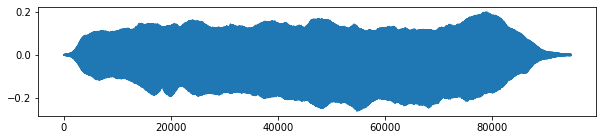

In [7]:
s.play()
s.plot()

In [8]:
s.duration, s.n_samples, len(s)

(2.149727891156463, 94803, 94803)

## Base Analysis

In [9]:
class Frame:
    def __init__(self, x: np.ndarray):
        self.x = x
    
    def plot(self):
        plot(self.x)

In [10]:
class Analysis:
    def __init__(self, 
                 signal: Signal,
                 frame_size: int, 
                 hop_size: int) -> None:
        self.signal = signal
        self.frame_size = frame_size
        self.hop_size = hop_size
    
    def __repr__(self) -> str:
        return f'Analysis({self.signal}, frame_size={self.frame_size}, hop_size={self.hop_size})'
    
    @property
    def overlap(self) -> int:
        return self.frame_size - self.hop_size
    
    @property
    def frames(self):
        x_pad = np.pad(self.signal.x, (self.overlap, 0), mode='constant')
        i = 0
        while i < x_pad.size:
            x_frame = x_pad[i:i+self.frame_size]
            if x_frame.size < self.frame_size:
                x_frame = np.pad(x_frame, (0, self.frame_size-x_frame.size), mode='constant')
            yield Frame(x_frame)
            i += self.hop_size
    
    @property
    def sample_rate(self):
        return self.signal.sample_rate

(636,
 Analysis(Signal("../../sms-tools/sounds/flute-A4.wav"), frame_size=601, hop_size=150))

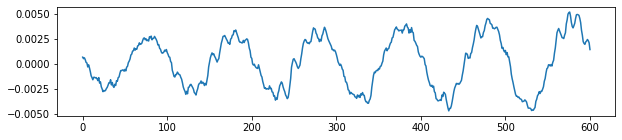

In [11]:
a = Analysis(s, frame_size=601, hop_size=150)
frames = list(a.frames)
frames[5].plot()
len(frames), a

## Spectral Analysis

In [12]:
class SpectralFrame(Frame):
    def __init__(self, frame: Frame, window: np.ndarray, fft_size: int):
        assert frame.x.size == window.size
        assert frame.x.size <= fft_size
        assert is_power_of_two(fft_size)
        super().__init__(frame.x * window)
        
        # instance variables
        self.frame = frame
        self.window = window
        self.fft_size = fft_size
        
        # lazy computed properties
        self._fft_buffer = None
        self._dft = None
        self._magnitudes = None
        self._magnitudes_db = None
        self._phases = None
    
    @property
    def fft_buffer(self):
        if self._fft_buffer is None:
            self._fft_buffer = zero_phase_buffer(self.x, n_fft=self.fft_size)
        return self._fft_buffer
    
    @property
    def dft(self):
        if self._dft is None:
            self._dft = np.fft.rfft(self.fft_buffer)
        return self._dft
    
    @property
    def magnitudes(self):
        if self._magnitudes is None:
            self._magnitudes = abs(self.dft)
        return self._magnitudes
    
    @property
    def magnitudes_db(self):
        if self._magnitudes_db is None:
            self._magnitudes_db = amplitude_to_decibels(self.magnitudes)
        return self._magnitudes_db
    
    @property
    def phases(self):
        if self._phases is None:
            dft = self.dft.copy()
            dft.real[abs(dft.real) < EPSILON] = 0.0
            dft.imag[abs(dft.imag) < EPSILON] = 0.0
            self._phases = np.unwrap(np.angle(dft))
        return self._phases
    
    def plot_magnitudes(self):
        return plot(self.magnitudes)
        
    def plot_magnitudes_db(self):
        return plot(self.magnitudes_db)
    
    def plot_phases(self):
        return plot(self.phases)

In [13]:
class SpectralAnalysis(Analysis):
    def __init__(self,
                 *args,
                 fft_size: int,
                 window_name: str,
                 **kwargs):
        super().__init__(*args, **kwargs)
        self.fft_size = fft_size
        self.window_name = window_name
        self.window = get_cola_window(window_name, self.frame_size, self.hop_size)
    
    @property
    def spectral_frames(self):
        for frame in super().frames:
            yield SpectralFrame(frame, self.window, self.fft_size)

In [14]:
sa = SpectralAnalysis(s, 
                      fft_size=2048,
                      window_name='hamming',
                      frame_size=601, 
                      hop_size=150)

In [15]:
frames = list(sa.frames)
sframes = list(sa.spectral_frames)

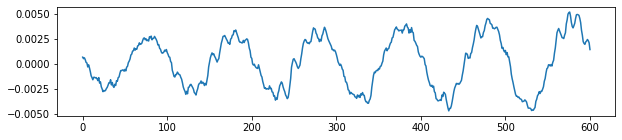

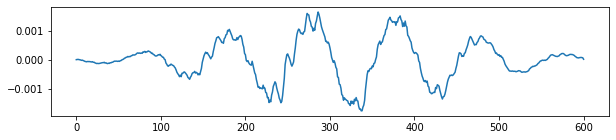

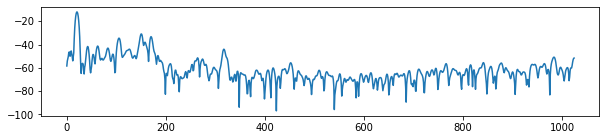

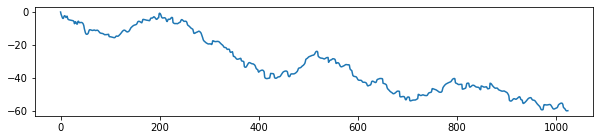

In [16]:
sf = sframes[5]
sf.frame.plot()
sf.plot()
sf.plot_magnitudes_db()
sf.plot_phases()

## Sine Model Analysis

In [17]:
class Peak:
    def __init__(self, frequency: float, magnitude: float, phase: float):
        self.frequency = frequency
        self.magnitude = magnitude
        self.phase = phase

In [49]:
class PeakAnalysisFrame(SpectralFrame):
    def __init__(self, *args, peak_threshold: float, sample_rate: int, **kwargs):
        super().__init__(*args, **kwargs)
        self.peak_threshold = peak_threshold
        self.sample_rate = sample_rate
        self._peaks = None
    
    @property
    def peaks(self):
        if self._peaks is None:
            peak_i = detect_peaks(self.magnitudes_db, self.peak_threshold)
            ipeak_i, ipeak_m = interpolate_peaks(self.magnitudes_db, peak_i)
            ipeak_f = ipeak_i * self.sample_rate / self.fft_size
            ipeak_p = np.interp(ipeak_i, np.arange(self.phases.size), self.phases)
            self._peaks = [Peak(f,m,p) for f,m,p in zip(ipeak_f, ipeak_m, ipeak_p)]
        return self._peaks
    
    def plot_peaks(self):
        ax = self.plot_magnitudes_db()
        for p in self.peaks:
            idx = p.frequency / self.sample_rate * self.fft_size
            ax.axvline(idx, color='red')
        

In [50]:
class PeakAnalysis(SpectralAnalysis):
    def __init__(self,
                 *args,
                 peak_threshold: float,
                 **kwargs):
        super().__init__(*args, **kwargs)
        self.peak_threshold = peak_threshold
    
    @property
    def peak_frames(self):
        for frame in super().frames:
            yield PeakAnalysisFrame(frame,
                                    window=self.window, 
                                    fft_size=self.fft_size,
                                    peak_threshold=self.peak_threshold,
                                    sample_rate=self.sample_rate)

In [51]:
pa = PeakAnalysis(s, 
                  fft_size=2048,
                  window_name='hamming',
                  frame_size=601, 
                  hop_size=150,
                  peak_threshold=-50)

In [52]:
pframes = list(pa.peak_frames)

In [53]:
frame = pframes[5]

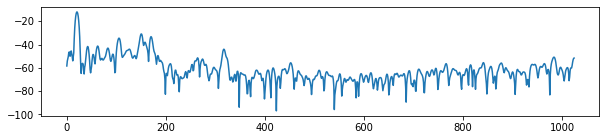

In [54]:
frame.plot_magnitudes_db()

In [55]:
[p.frequency for p in frame.peaks[:4]]

[99.66269679925341, 185.41168309332494, 440.9719823095766, 907.1587704941988]

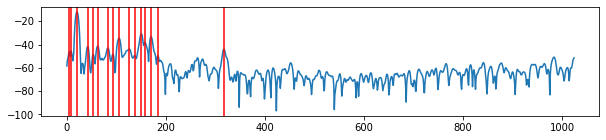

In [56]:
frame.plot_peaks()

In [57]:
fig.plot(np.arange(5))

AttributeError: 'Figure' object has no attribute 'plot'

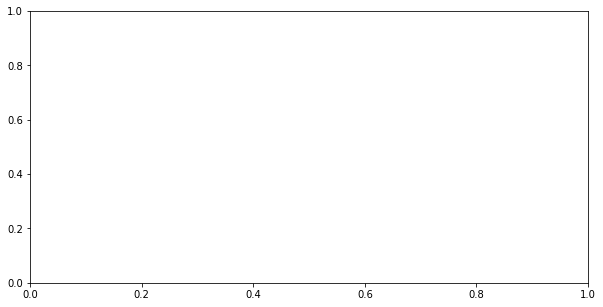

In [48]:
fig, ax = plt.subplots(1, figsize=(10,5))